In [3]:
import pandas as pd
import time
import numpy as np
import arcgis

#plotting
from IPython.display import HTML, display
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter
import matplotlib as mpl
mpl.rc('xtick', color='w')
mpl.rc('ytick', color='w')
%matplotlib inline

In [4]:
df = arcgis.SpatialDataFrame()
df = df.from_featureclass(r'C:\Users\dani9510\Documents\ArcGIS\Projects\Utah Accidents Demo\Utah Accidents Demo.gdb\UtahCollisions_OnRoads')

In [5]:
# remove data away from known roads or null geometry
df = df.dropna(how='any',subset=['SegID'])
df = df[df.SegID > 0]
df.loc[df.aadt_vn == 0,'aadt_vn'] = np.nan
df['CRASHDATE'] = df['CRASHDATE'].astype('str')
df['CRASHTIME'] = df['CRASHTIME'].astype('str')
df['timestamp'] = pd.to_datetime(df['CRASHDATE']+' '+df['CRASHTIME'])
df['agg'] = 1
time_index = pd.DatetimeIndex(df['timestamp'])

df['hour'] = time_index.hour
df['weekday'] = time_index.weekday
df['month'] = time_index.month

df = df.set_index(time_index)
ts = df.resample('1h').sum()

70128
72


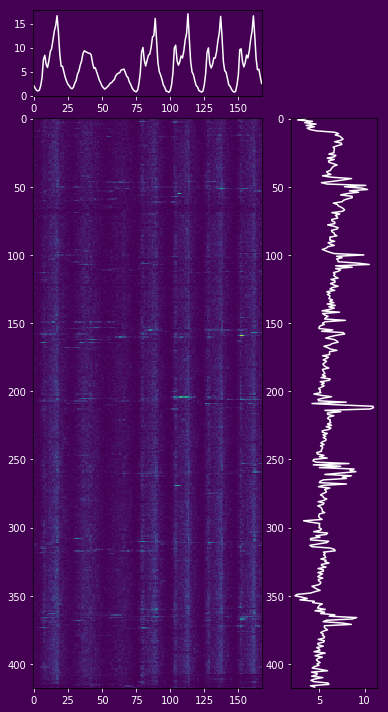

In [6]:
fig = plt.figure(figsize=(10,10))
fc = np.array(viridis[0])
fc = fc / 255.0
fig.set_facecolor(fc)
hourly_count = ts['agg'].values
N = hourly_count.size
print (N)
print (N%(24*7))
hourly_count = np.resize(hourly_count,N+(24*7-N%(24*7)))
hourly_count = np.reshape(hourly_count,(-1,24*7))

xAgg = np.mean(hourly_count,axis=0)
yAgg = np.mean(hourly_count,axis=1)

nullfmt = NullFormatter()         # no labels
axIm = plt.gca()
axIm.imshow(hourly_count)

# create new axes on the right and on the top of the current axes.
divider = make_axes_locatable(axIm)
axX = divider.append_axes("top", size=1.2, pad=0.3, sharex=axIm)
axY = divider.append_axes("right", size=1.2, pad=0.4, sharey=axIm)

nt,nh = hourly_count.shape

axX.plot(np.arange(nh),xAgg,'w-')
axY.plot(yAgg,np.arange(nt)[::-1],'w-')
axY.margins(y=0)
axX.margins(x=0)
axX.set_facecolor(fc)
axY.set_facecolor(fc)
plt.tight_layout()
plt.gca().set_aspect('auto')

In [7]:
try:
    df['DDLat'] = df['DDLat'].apply(lambda x: float(x[:-1]))
    df['DDLon'] = df['DDLon'].apply(lambda x: float(x[:-1]))
except TypeError:
    pass # We've already done it

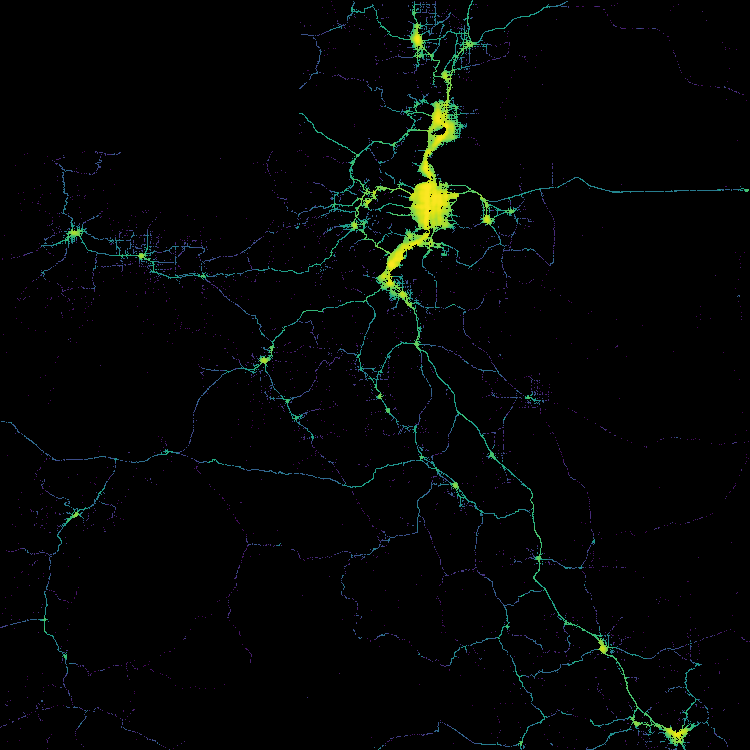

In [8]:
canvas = ds.Canvas(750,750)
agg = canvas.points(df, 'DDLon','DDLat',ds.mean('KDE_Severity'))
img = tf.shade(agg, cmap=viridis)
tf.set_background(img, 'black')